In [1]:
## Import statements

import openmc
import openmc.deplete
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
from math import pi
import xml.etree.ElementTree as et
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Analysis Specifications
keffAnalyze = False
depletionAnalyze = True

depletionAnalyzed = False

In [3]:
# Dimensional Parameters

trisoPkFrac = 0.6 # ratio of triso particle volume to total pebble volume
pebblePkFrac = 0.64 # ratio of pebble volume to core volume

reflctThickness = 66 # cm
coreRadius = 50 # cm
coreHeight = 125 # cm

erchPercent = 19.75 / 100
U_form = 1;
O_form = 2;
rho_fuel = 10.96; # g/cm3

trisoPartThicknesses = [253.5, 97.7, 41.9, 37.5, 45.6]; # um

coolTemp = 450+273.15 #C -> K
coolPres = 8 #MPa

In [4]:
# Material Definitions

#      Buffer
buffer = openmc.Material(name='Buffer')
buffer.set_density('g/cm3', 1.0)
buffer.add_element('C', 1.0)

#      IPyC
IPyC = openmc.Material(name='IPyC')
IPyC.set_density('g/cm3', 1.9)
IPyC.add_element('C', 1.0)

#      SiC
SiC = openmc.Material(name='SiC')
SiC.set_density('g/cm3', 3.2)
SiC.add_element('C', 0.5)
SiC.add_element('Si', 0.5)

#      OPyC
OPyC = openmc.Material(name='OPyC')
OPyC.set_density('g/cm3', 1.87)
OPyC.add_element('C', 1.0)

# Moderator
graphite = openmc.Material()
graphite.set_density('g/cm3', 1.1995)
graphite.add_element('C', 1.0)

# Coolant
He = openmc.Material(name='He')
He.set_density('g/cm3',coolPres/coolTemp/2.0771)
He.add_element('He',1.0)
He.temperature = coolTemp

# Reflector
Refl = openmc.Material(name='Reflector')
Refl.set_density('g/cm3',1.72)
Refl.add_element('C',1.0)
Refl.add_s_alpha_beta('c_Graphite')


In [5]:
#TRISO Particle Volume Fraction Calculations
trisoPartRads = trisoPartThicknesses
for i in range(1,5):
    trisoPartRads[i] += trisoPartRads[i-1]
trisoPartVolFracs = trisoPartRads
for i in range(5):
    trisoPartVolFracs[i] = (trisoPartRads[i]/trisoPartRads[4])**3
for i in range(4):
    trisoPartVolFracs[4-i] -= trisoPartVolFracs[3-i]

In [6]:
#Pebble Volume Fraction Calculations
pebbleRads = [25, 30]
pebbleVolFracs = pebbleRads
for i in range(2):
    pebbleVolFracs[i] = (pebbleRads[i]/pebbleRads[1])**3
pebbleVolFracs[1] -= pebbleVolFracs[0]

In [7]:
#Fuel Kernel Material definition
fuel = openmc.Material(name="fuel")
fuel.set_density('g/cm3', rho_fuel)
fuel.add_nuclide('U235',erchPercent*U_form/(U_form+O_form))
fuel.add_nuclide('U238',((1-erchPercent)*U_form/(U_form+O_form)))
fuel.add_element('O', O_form/(U_form+O_form))
homogTrisoPart = openmc.Material.mix_materials([fuel, buffer, IPyC, SiC, OPyC], trisoPartVolFracs, 'vo')

In [8]:
# Homogenize Pebbles
homogTrisoPebCore = openmc.Material.mix_materials([homogTrisoPart,graphite], [trisoPkFrac, 1-trisoPkFrac], 'vo')
homogTrisoPebble = openmc.Material.mix_materials([homogTrisoPebCore, graphite], pebbleVolFracs, 'vo')

In [9]:
# Core Homogenization and material definition
homogCore = openmc.Material.mix_materials([homogTrisoPebble, He], [pebblePkFrac, 1-pebblePkFrac], 'vo', 'homogCore')
homogCore.add_s_alpha_beta('c_Graphite')
homogCore.volume = math.pi*math.pow(coreRadius, 2)*coreHeight


In [10]:
# Materials File Creation and Export
materials = openmc.Materials()
materials += [Refl, homogCore]
materials.export_to_xml()

In [11]:
# Core Model
core = openmc.model.RightCircularCylinder([0,0,0], coreHeight, coreRadius, axis='z', boundary_type = 'transmission')
rflctr = openmc.model.RightCircularCylinder([0,0,-reflctThickness],2*reflctThickness+coreHeight,reflctThickness+coreRadius, axis ='z',boundary_type = 'vacuum') 
rxr = openmc.Cell(fill=homogCore, region=-core)
reflect = openmc.Cell(fill = Refl, region =+core&-rflctr)
surr = openmc.Cell(region =+rflctr)
universe = openmc.Universe(cells=[rxr, reflect, surr])
geometry = openmc.Geometry()
geometry.root_universe = universe
geometry.export_to_xml()

In [12]:
# Settings
settings = openmc.Settings()
settings.run_mode = 'eigenvalue'
settings.particles = 100000
settings.batches = 75
settings.inactive = 15
settings.temperature={'method':'interpolation','range':(250,2500)}
settings.export_to_xml()

In [13]:
# Keff Analysis
if keffAnalyze:
    num_threads_des = 136  # set as desired.  Can be useful to ensure you do not take over all the resources for a machine
    num_threads = min(os.cpu_count(),num_threads_des); # prevent asking for more threads than OMP_NUM_THREADS
    openmc.run(output=True)
    sp = openmc.StatePoint('statepoint.45.h5')
    keff = sp.keff
    sp.close()
    keffAnalyze = False

In [22]:
if depletionAnalyze:
    if os.path.isfile("model.xml"):
        os.remove("model.xml")
        print("Previous model file removed\n\n")
    mdl = openmc.model.Model(geometry, materials, settings)
    op = openmc.deplete.CoupledOperator(mdl,"chain_endfb71_pwr.xml")
    p = 5e6  # watts
    power =         [p,     p,  p, p, p, p,    p, p,    p,  0,  0,  0,    0];
    timesteps =     [.25, .25, .5, 1, 5, 14, 159, 185, 180, 1, 179, 185, 180]  # days
    openmc.deplete.CECMIntegrator(op, timesteps, power, timestep_units='d').integrate()
    results = openmc.deplete.Results("depletion_results.h5")
    depletionAnalyze = False
    depletionAnalyzed = True


In [16]:
if depletionAnalyzed:
    time, KEFF= results.get_keff()
    time = time / (60*60*24*365.25);
    keff_u = []
    keff = []
    for k in KEFF:
        keff_u.append(k[1])
        keff.append(k[0])

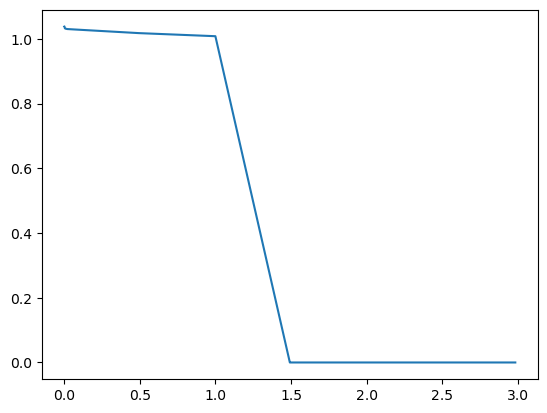

In [17]:
if depletionAnalyzed:
    plt.errorbar(np.array(time), np.array(keff), np.array(keff_u))

In [18]:
# get depletion results to manipulate
r = openmc.deplete.Results('depletion_results.h5')
bi = len(timesteps)
burned_mats = r.export_to_materials(burnup_index=bi)
xmlName = 'BurnedMaterials'+str(bi)+'.xml'
burned_mats.export_to_xml(xmlName)
mat_tree = et.parse(xmlName)
root = mat_tree.getroot()
i=0
for child in root:
    if child.attrib['name']=='homogCore':
        homogCore = root[i]
        break
    i+=1
homogCore.set('id',24)
print(homogCore.items())
type(homogCore)
burned_homogCore = openmc.Material.from_xml_element(homogCore)
burned_homogCore_mass = burned_homogCore.get_mass()
listnuc = burned_homogCore.get_nuclides() # list of nuclides present in burned fuel
import re
Puiso = []
for nuclide in listnuc:
    if re.search('Pu.+', nuclide):
        Puiso.append(nuclide)
pu_mass =0.
for nuclide in Puiso:
    pu_mass+=burned_homogCore.get_mass(nuclide=nuclide)
pu_mass_fraction = pu_mass/burned_homogCore_mass
SepPu = openmc.Material(name='PuProduct')
SepPu.set_density('g/cc',19.84) # density used for all metallic Plutonium in PNNL Compendium
print(Puiso)
i = len(Puiso)
n = 0
BurnPuAo = []
while (n < i):
    BurnPu = burned_homogCore.get_nuclide_atom_densities(Puiso[n])
    BurnPuAo.append(BurnPu)
    SepPu.add_nuclide(Puiso[n],BurnPu[Puiso[n]])
    n+=1

[('depletable', 'true'), ('id', 24), ('name', 'homogCore'), ('volume', '981747.7042468104')]
['Pu237', 'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242', 'Pu243', 'Pu244', 'Pu245', 'Pu246']


In [19]:
def build_model(radius, fuel):
    
    
    materials = openmc.Materials([fuel])
    
    # create sphere with radius parameter
    sphere_radius = openmc.Sphere(x0=0,y0=0,z0=0,r=radius, boundary_type='vacuum', name='BCM')
    
    # create core cell
    core_cell = openmc.Cell(name='Bare Critical Sphere')
    core_cell.fill = fuel
    core_cell.region = -sphere_radius
    
    # create universe geometry
    root_universe = openmc.Universe(name='root universe')
    root_universe.add_cells([core_cell])
    
    geometry = openmc.Geometry(root_universe)
    # define criticality settings
    settings = openmc.Settings()
    settings.run_mode = 'eigenvalue' # keff calculation
    settings.particles = 5000 # particles per batch (mo betta)
    settings.batches = 250 # number of batches
    settings.inactive = 50 # inactive batches
    
    settings.output = {'tallies': False}
    
    bcmModel = openmc.model.Model(geometry,materials,settings)
    
    return bcmModel

In [20]:
crit_r, guesses, keffs = openmc.search_for_keff(build_model, bracket=[1,50],model_args={'fuel':SepPu},
                                                tol=1e-4, print_iterations=True,
                                               run_args={'output':False})
# print results and collect data
print('Burned Plutonium Critical Mass')
print('The bare critical sphere radius is %7.4f cm.' % crit_r)
crit_v = 4/3*pi*crit_r**3 # volume of critical sphere (cc)

BCM = crit_v * 19.84 /1000 # mass of critical radius (kg)
print('The bare critical mass is %7.3f kg.' % BCM)

BCMs = np.array(BCM)
print(BCMs,'\n')


Iteration: 1; Guess of 1.00e+00 produced a keff of 0.22081 +/- 0.00015
Iteration: 2; Guess of 5.00e+01 produced a keff of 2.83817 +/- 0.00080
Iteration: 3; Guess of 2.55e+01 produced a keff of 2.55948 +/- 0.00106
Iteration: 4; Guess of 1.32e+01 produced a keff of 2.00140 +/- 0.00111
Iteration: 5; Guess of 7.12e+00 produced a keff of 1.34299 +/- 0.00084
Iteration: 6; Guess of 4.06e+00 produced a keff of 0.83964 +/- 0.00054
Iteration: 7; Guess of 5.59e+00 produced a keff of 1.10427 +/- 0.00073
Iteration: 8; Guess of 4.83e+00 produced a keff of 0.97620 +/- 0.00063
Iteration: 9; Guess of 5.21e+00 produced a keff of 1.04296 +/- 0.00068
Iteration: 10; Guess of 5.02e+00 produced a keff of 1.00866 +/- 0.00067
Iteration: 11; Guess of 4.92e+00 produced a keff of 0.99281 +/- 0.00062
Iteration: 12; Guess of 4.97e+00 produced a keff of 1.00099 +/- 0.00063
Iteration: 13; Guess of 4.95e+00 produced a keff of 0.99652 +/- 0.00067
Iteration: 14; Guess of 4.96e+00 produced a keff of 0.99948 +/- 0.00066
I

In [85]:
netWeight = BCM/pu_mass_fraction
print('Net Weight:  '+str(netWeight) + ' kg')
netVolume = netWeight/burned_homogCore.get_mass_density()/1e3
netRadius = math.pow((.75*netVolume/math.pi),1/3)*100

Net Weight:  12303.553924895725 kg


In [34]:
specificActivity = burned_homogCore.get_activity('Bq/g')
print('Core material specific activity is %5.3g Bq/g ' % specificActivity)
print('Core material specific activity is %5.3g Ci/kg ' % (specificActivity*2.7e-8))
minActivity = specificActivity*2.7e-8*netWeight
print('Net weight material activity is %5.3g MCi' % (minActivity*1e-6))

Core material specific activity is 3.18e+09 Bq/g 
Core material specific activity is  85.9 Ci/kg 
Net weight material activity is  1.06 MCi


In [76]:
openmc.config['chain_file'] = "chain_endfb71_pwr.xml"
specificActivityg = burned_homogCore.get_decay_photon_energy(units='Bq/g').integral()
print('Core material specific activity (gamma) is %5.3g Bq/g ' % specificActivityg)
print('Core material specific activity (gamma) is %5.3g Ci/kg ' % (specificActivityg*2.7e-8))
minActivityg = specificActivityg*1e3*netWeight #Bq
print('Net weight material activity (gamma) is %5.3g kCi' % (minActivityg*2.7e-11

Core material specific activity (gamma) is 4.72e+08 Bq/g 
Core material specific activity (gamma) is  12.7 Ci/kg 
Net weight material activity (gamma) is   157 kCi


In [108]:
specificHeatGen = SepPu.get_decay_heat(units='W/g')
print('NED material specific heat generation is %5.3g W/kg ' % (specificHeatGen*1e3))
heatGen = specificHeatGen*BCM*1e3
print('NED material heat generation is %5.3g W ' % heatGen)

NED material specific heat generation is  2.14 W/kg 
NED material heat generation is  21.7 W 
